<a href="https://colab.research.google.com/github/hermionewarr/Transfer_learning_sarcopenia_C3/blob/main/3_running_saved_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load in data to run the saved model on


In [ ]:
!pip install segmentation-models-pytorch

#C3s automated

In [ ]:
data = np.load("/content/1_27plusminus5.npz", allow_pickle=True)
[*data.keys()]

['slices', 'ids', 'pixel_areas', 'bone_masks']

In [ ]:
slices = data['slices']
ids = data['ids']
bone_masks = data['bone']
areas = data['areas']

KeyError: ignored

0.0 1.0
0.0 1.0
(197, 260, 260)


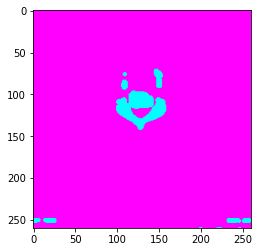

In [ ]:
slices_processed, masks_processed = preprocess(slices, bone_masks)
print(slices_processed[0].min(), slices_processed[0].max())
print(masks_processed[0].min(), masks_processed[0].max())
print(slices_processed.shape)
plt.imshow(masks_processed[0], cmap = 'cool')

In [ ]:
test_transform = A.Compose(
    [A.Resize(260, 260), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensor()]
)

In [ ]:
test_dataset = H_custom_Dataset(slices_processed, bone_masks, transform = test_transform)
test_dataloader = DataLoader(test_dataset, batch_size = 8, num_workers = 2, shuffle = False)

segmenting the c3s

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
c3s, test_predictions = test(model, test_dataloader)
print(test_predictions.shape, c3s.shape)

In [ ]:
print(test_predictions.shape)
test_predictions = torch.from_numpy(test_predictions)
segment_pred_slb = np.logical_and(test_predictions, bone_masks[:,np.newaxis,...])
segment_pred_slb = (segment_pred_slb.float()).numpy()
print(np.unique(segment_pred_slb))


(197, 1, 260, 260)
[0. 1.]


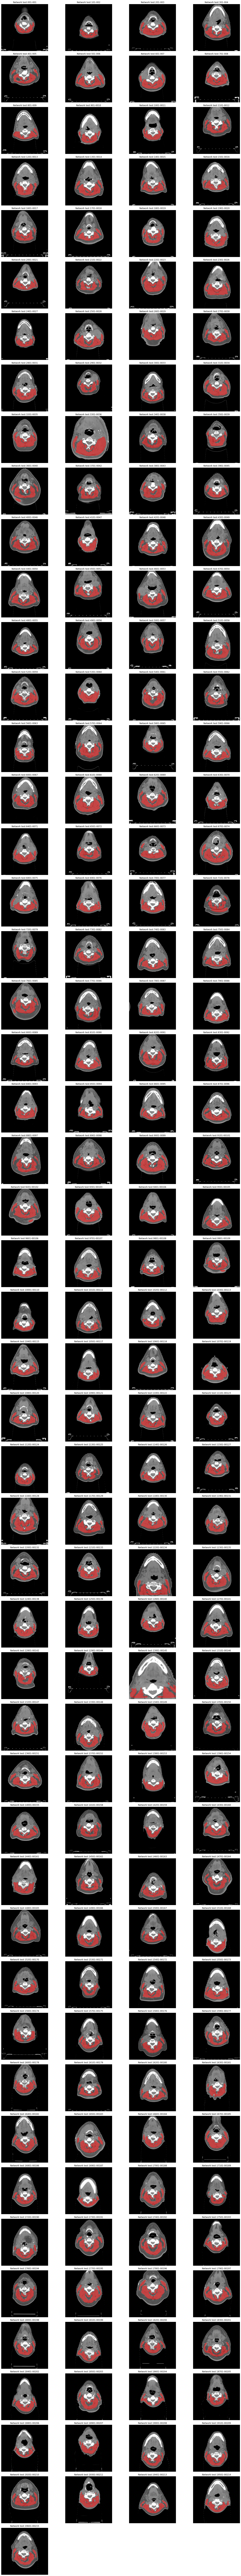

In [ ]:
fig=plt.figure(figsize=(20, 200))
ax = []
rows = 50
columns = 4
for i in range(0, len(slices)):
  ax.append(fig.add_subplot(rows,columns, i+1))
  segment_pred_slb[i][segment_pred_slb[i]==0] = np.nan
  plt.imshow(c3s[i,0,...], cmap="gray")
  plt.imshow(segment_pred_slb[i,0,...], cmap = "autumn", alpha = 0.5)
  #plt.imshow(test_lab[i,0,...], alpha= 0.5)
  ax[-1].set_title("Network test:"+str(i) +ids[i])
  plt.axis("off")
plt.tight_layout(True)
plt.show()

getting the area and density

In [ ]:
from functools import partial

In [ ]:
def getDensity(image, mask, area, label=1):#pixel density
  if image.shape != (len(image),1,...):
    mask = np.squeeze(mask)
  # remove image.data since passing array
  return float(np.mean(image[np.where(mask == 1)]))#-1024

pixel area for each of my data bits. need to make sure they match up maybe add to array with identities.

In [ ]:
pixel_area = np.array(areas)*(0.1*0.1)#cm^2
print(pixel_area)

[0.00878906 0.00878906 0.00878906 0.00878906 0.00878906 0.00878906
 0.00878906 0.00878906 0.00878906 0.00878906 0.00953674 0.00953674
 0.00953674 0.00953674 0.00953674 0.00953674 0.00953674 0.00953674
 0.00953674 0.00953674 0.00953674 0.00953674 0.00953674 0.00953674
 0.00953674 0.00953674 0.00953674 0.00953674 0.00953674 0.00953674
 0.00878906 0.00878906 0.00878906 0.00878906 0.00878906 0.00878906
 0.00878906 0.00878906 0.00878906 0.00878906 0.00953669 0.00953669
 0.00953669 0.00953669 0.00953669 0.00953669 0.00953669 0.00953669
 0.00953669 0.00953669 0.00953669 0.00953669 0.00953669 0.00953669
 0.00953669 0.00953669 0.00953669 0.00953669 0.00953669 0.00953669
 0.00878906 0.00878906 0.00878906 0.00878906 0.00878906 0.00878906
 0.00878906 0.00878906 0.00878906 0.00878906 0.00953673 0.00953673
 0.00953673 0.00953673 0.00953673 0.00953673 0.00953673 0.00953673
 0.00953673 0.00953673 0.00878906 0.00878906 0.00878906 0.00878906
 0.00878906 0.00878906 0.00878906 0.00878906 0.00878906 0.0087

In [ ]:
def getArea(image, mask, area, label=1, thresholds = None):
  sMasks = (mask == label)
  threshold = np.logical_and(image > (thresholds[0]), image <  (thresholds[1]))
  tmask = np.logical_and(sMasks, threshold)
  #np.count_nonzero(tmask)
  return np.count_nonzero(tmask) * area

In [ ]:
## Note that the areas have some thresholds applied that are from the literature
extractionDict = {"sma" : partial(getArea, thresholds=(-30, +130)), 
				  "smd" : partial(getDensity)
				 }
feat_list_1 = ["sma","smd"]
#feat_list_2 = ["sma","smd"]
# Extract features from slices_processed
feature_list_net = []
#feature_list_ours = []
for i in range(0,len(slices)):
  feature_list_net.append([extractionDict[a](slices[i], segment_pred_slb[i], pixel_area[i]) for a in feat_list_1])
  #feature_list_ours.append([extractionDict[a](slices[i], test_lab[i], pixel_area_id[i]) for a in feat_list_2])

In [ ]:
print("Area, Density of nets predictions", feature_list_net)
#print("Area, Density of ours", feature_list_ours)

Area, Density of nets predictions [[26.147460937500004, 35.297799814068796], [26.516601562500004, 35.34305682163476], [24.205078125000004, 35.18125], [22.113281250000004, 33.38926413082119], [22.886718750000004, 33.00965850293205], [22.543945312500004, 29.28658125421443], [23.466796875000004, 28.32359623498864], [23.783203125000004, 27.93188951663528], [22.412109375000004, 24.704258150365934], [22.570312500000004, 22.522824302134648], [22.745132446289066, 33.347611827141776], [21.61979675292969, 24.47482014388489], [20.97129821777344, 26.241594996090697], [20.751953125000004, 27.2873427672956], [20.027160644531254, 24.576271186440678], [19.39773559570313, 16.025518341307816], [20.04623413085938, 18.71674491392801], [21.23832702636719, 17.247343349212166], [19.531250000000004, 16.229357798165136], [18.44406127929688, 9.818948213568849], [52.785873413085945, 41.981638662740345], [49.63874816894532, 42.07475083056478], [49.59106445312501, 38.51109481019622], [49.01885986328126, 35.6534122

#Sarcopenia Value

Looking at the skeletal muscle area. SMI.

In [ ]:
#smas = [f[0] for f in feature_list] #list way of doing it
#for the network
sma = np.array(feature_list_net)[:,0]
mean_area = np.mean(sma)
area_sd = ndimage.standard_deviation(sma)
print(mean_area, "cm^2 ", "sd: ", area_sd)

38.71110872906984 cm^2  sd:  9.049207158068509


skeletal muscle density SMD

In [ ]:
smd = np.array(feature_list_net)[:,1]#sm attenuation
mean_density = np.mean(smd)
den_sd = ndimage.standard_deviation(smd)
print(mean_density, "HU" ,"sd", den_sd)

34.552879370444195 HU sd 7.891235814574613


In [ ]:
import pandas as pd

array = np.transpose(np.array(feature_list_net))
print(array)


[[26.14746094 26.51660156 24.20507813 22.11328125 22.88671875 22.54394531
  23.46679688 23.78320313 22.41210938 22.5703125  22.74513245 21.61979675
  20.97129822 20.75195313 20.02716064 19.3977356  20.04623413 21.23832703
  19.53125    18.44406128 52.78587341 49.63874817 49.59106445 49.01885986
  50.32539368 50.63056946 50.82130432 49.70550537 49.58152771 47.83630371
  38.78613281 38.83007813 38.75097656 38.79492188 37.57324219 38.56640625
  38.48730469 36.75585938 35.69238281 33.31933594 44.89875662 44.64126588
  43.53500934 42.12357859 38.34704766 37.98465328 38.35658435 39.79662519
  38.9383227  37.32662137 54.54035453 51.12621798 49.71478723 49.28563599
  48.79926458 49.08536541 48.46548028 46.96821928 45.03227034 42.72439033
  50.00097656 49.26269531 49.47363281 48.54199219 47.79492188 45.18457031
  45.67675781 45.421875   45.11425781 44.40234375 53.15775448 52.9097994
  49.49564869 46.38667345 43.77360838 43.6114839  43.83082878 41.59923306
  39.21504959 37.50797424 35.34960938 3

In [ ]:
df = pd.DataFrame(array, index= feat_list_1, columns=ids).T
df.to_excel(excel_writer = "/content/muscle_area_and_density_all_slb_abstract.xlsx")

Debugging the saving line 

In [ ]:
model1 = models.segmentation.fcn_resnet50(pretrained=False, num_classes=1)
path = "/content/model_state_dict_300_FL_testing.pt"
model1.load_state_dict(torch.load(path, map_location="cuda:0"))


<All keys matched successfully>

output shape:  torch.Size([10, 1, 260, 260])
[0. 1.]
(10, 1, 260, 260) (10, 3, 260, 260)


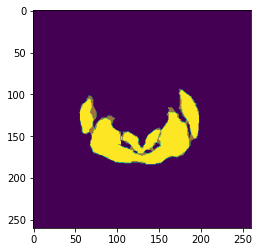

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device)
c3s, test_predictions = test(model1, test_dataloader)
print(test_predictions.shape, c3s.shape)

#plt.imshow(masks_test[1], alpha =0.5)
plt.imshow(test_predictions[1,0,...])
plt.imshow(masks_test[1], alpha =0.5)

In [ ]:
dice_array = []

dice_net_v_pred = diceCoeff(test_predictions, test_lab, smooth=1, activation=None)

print("dice_net_v_pred", dice_net_v_pred)
mean = np.mean(dice_net_v_pred.item())

print(mean)

ValueError: ignored

#Below should do everything but check before deleting code above then stick in github

In [ ]:
#imports
from __future__ import division
import matplotlib.pyplot as plt
#import SimpleITK as sitk
import numpy as np
import os
from scipy import ndimage
import cv2
from google.colab.patches import cv2_imshow
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import segmentation_models_pytorch as smp
from PIL import Image
import time
import copy
from tqdm import tqdm
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import albumentations as A
import random
from albumentations.pytorch import ToTensor
from functools import partial
import pandas as pd

#defs
def preprocess(slice_array, masks_array):
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  window = 350
  level = 50
  size = len(masks_array)
  vmin = (level/2) - window
  vmax = (level/2) + window
  processed_slices = []
  processed_masks = (np.nan_to_num(masks_array)).astype(np.float64)
  for i in range (0, size):
    slice_array[i][slice_array[i]>vmax] = vmax
    slice_array[i][slice_array[i]<vmin] = vmin
    shape = slice_array[i].shape
    image_scaled = np.round(sklearn.preprocessing.minmax_scale(slice_array[i].ravel(), feature_range=(0,1)), decimals = 10).reshape(shape)
    processed_slices.append(image_scaled)
    processed_masks[i][processed_masks[i]>1] = 1
  processed_slices = np.array(processed_slices)
  return processed_slices, processed_masks

def diceCoeff(pred, gt, smooth=1, activation='sigmoid'):
    """ computational formula：
        dice = (2 * (pred ∩ gt)) / (pred ∪ gt)
    """
    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = nn.Softmax2d()
    else:
        raise NotImplementedError("Activation implemented for sigmoid and softmax2d activation function operation")
 
    pred = np.round(activation_fn(pred))
    N = gt.size(0) #n should be batch size
    pred_flat = pred.view(N, -1)
    gt_flat = gt.view(N, -1)
 
    intersection = (pred_flat * gt_flat).sum(1)
    unionset = pred_flat.sum(1) + gt_flat.sum(1)
    print(intersection, unionset)
    loss = (2 * intersection + smooth) / (unionset + smooth)
 
    return loss.sum() / N

def genTransforms(slice_array, masks_array):
  transform_slices = []
  transform_masks = []
  size = len(masks_array)
  slices_3chan = []
  #masks = masks_array[:,np.newaxis,:,:]
  if slice_array.shape != (size,3,...):
    slices_3chan = np.repeat(slice_array[:,:,:,np.newaxis], 3, axis=-1)
    for i in range (0,len(masks_array)):
      slices_3chan[i,:,:,1] = ndimage.gaussian_laplace(slices_3chan[i,:,:,1], sigma=1)
      slices_3chan[i,:,:,2] = ndimage.sobel(slices_3chan[i,:,:,2])
    #plt.imshow(slices_3chan[:,2,...], cmap = "gray")
    #slice_array = np.moveaxis(slices_3chan, 3,1)
  transform_slice = slices_3chan.astype(np.float32)
  transform_mask = masks_array.astype(np.float32)
  return transform_slice, transform_mask

def test(model, test_dataloader):
    model.eval()
    segments = []
    c3s = []

    for int, data in enumerate(test_dataloader):
        slices_test = data[0].to(device)
        slices_test = slices_test.type(torch.float32)
        output = model(slices_test)["out"]
        #print("output shape: ", output.shape)
        test_ouput = output.detach().cpu()
        slices_test = slices_test.detach().cpu()
        sigmoid = 1/(1 + np.exp(-test_ouput))
        segment = (sigmoid > 0.5).float()
        #print(np.unique(segment))
        #print(int)
        if int == 0:
          segments = segment
          c3s = slices_test
        else:
          segments = np.append(segments, np.array(segment), axis = 0)
          c3s = np.append(c3s, np.array(slices_test), axis = 0)
  
    segments = np.array(segments)
    c3s = np.array(c3s)
    return c3s, segments

def getDensity(image, mask, area, label=1):#pixel density
  if image.shape != (len(image),1,...):
    mask = np.squeeze(mask)
  # remove image.data since passing array
  return float(np.mean(image[np.where(mask == 1)]))#-1024

def getArea(image, mask, area, label=1, thresholds = None):
  sMasks = (mask == label)
  threshold = np.logical_and(image > (thresholds[0]), image <  (thresholds[1]))
  tmask = np.logical_and(sMasks, threshold)
  #np.count_nonzero(tmask)
  return np.count_nonzero(tmask) * area

#classes
class H_custom_Dataset(TensorDataset):
    def __init__(self, images, masks, transform=None):
        super(H_custom_Dataset, self).__init__() #dont know what this does find out
        self.transform = transform
        self.images, self.masks  = genTransforms(images, masks)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      if self.transform:
        augmentations = self.transform(image=self.images[idx], mask=self.masks[idx])
        image = augmentations["image"]
        mask =augmentations["mask"]
      else:
        image = self.images
        mask = self.masks
      return image, mask



In [ ]:
#Loading the data
data = np.load("/content/1_27plusminus5.npz", allow_pickle=True)
print([*data.keys()])
slices = data['slices']
bone = data['bone_masks']
ids = data['ids']
areas = data['pixel_areas']
#ids_areas_dic = {ids: areas}#dictionary?

slices_processed, masks_processed = preprocess(slices, bone)
test_transform = A.Compose([A.Resize(260, 260), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensor()])

test_dataset = H_custom_Dataset(slices_processed, masks_processed, transform = test_transform)
test_dataloader = DataLoader(test_dataset, batch_size = 8, num_workers = 2, shuffle = False)

In [ ]:
#initilaise and load the model
model = models.segmentation.fcn_resnet50(pretrained=False, num_classes=1)
path = "/content/model_state_dict_300_FL_testing.pt"
model.load_state_dict(torch.load(path, map_location="cuda:0"))#, map_location="cuda:0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
c3s, test_predictions = test(model, test_dataloader)
#print(test_predictions.shape, c3s.shape)   

print(test_predictions.shape)
test_predictions = torch.from_numpy(test_predictions)
segment_pred_slb = np.logical_and(test_predictions, bone[:,np.newaxis,...])
segment_pred_slb = (segment_pred_slb.float()).numpy()
test_predictions = (test_predictions.float()).numpy()
print(np.unique(segment_pred_slb))
"""
#dice scores
dice_net_v_pred = diceCoeff(test_predictions, bone, smooth=1, activation=None)

print("dice_net_v_pred", dice_net_v_pred)
mean = np.mean(dice_net_v_pred.item())
print(mean)
"""

In [ ]:
#skeletal muscle area and density
ct_scans = np.array(slices)#or slices processed
pixel_areas = np.array(areas)*(0.1*0.1)#cm^2
## Note that the areas have some thresholds applied that are from the literature
extractionDict = {"sma" : partial(getArea, thresholds=(-30, +130)), 
				  "smd" : partial(getDensity)
				 }
feat_list_1 = ["sma","smd"]
# Extract features from slices_processed
feature_list_net = []
for i in range(0,len(ct_scans)):
  feature_list_net.append([extractionDict[a](ct_scans[i], segment_pred_slb[i], pixel_areas[i]) for a in feat_list_1])

#print("Area, Density of nets predictions", feature_list_net)

#smas = [f[0] for f in feature_list] #list way of doing it
#for the network
sma = np.array(feature_list_net)[:,0]
mean_area = np.mean(sma)
area_sd = ndimage.standard_deviation(sma)
print(mean_area, "cm^2 ", "sd: ", area_sd)

smd = np.array(feature_list_net)[:,1]#sm attenuation
mean_density = np.mean(smd)
den_sd = ndimage.standard_deviation(smd)
print(mean_density, "HU" ,"sd", den_sd)

#split them up for each array every ten
for i in range (0, 10):
  #smd_+str(i) = smd[i::10]
  print(i-5, " mean :", np.mean(smd[i::10]), " sd: ", ndimage.standard_deviation(smd[i::10]))

#smd_plus_minus_array = np.savez("/content/smd_plus_minus_array.npz", smd = smd, sma = sma, slices = slices, ids = ids, predictions = segment_pred_slb)
#smd = np.array(smd)
#print(smd.shape())

"""
#save the smas and smds
array = np.transpose(np.array(feature_list_net))
print(array)
df = pd.DataFrame(array, index= feat_list_1, columns=ids).T
df.to_excel(excel_writer = "/content/muscle_area_and_density_all_slb_abstract.xlsx")
"""

In [ ]:
"""
#display the predictions
fig=plt.figure(figsize=(10, 120))
ax = []
columns = 4
rows = int(len(slices)/columns + 0.5)
for i in range(0, len(slices)):
  ax.append(fig.add_subplot(rows,columns, i+1))
  segment_pred_slb[i][segment_pred_slb[i]==0] = np.nan
  plt.imshow(c3s[i,0,...], cmap="gray")
  plt.imshow(segment_pred_slb[i,0,...], cmap = "autumn", alpha = 0.5)
  #plt.imshow(test_lab[i,0,...], alpha= 0.5)
  ax[-1].set_title("Network test:" + ids[i])
  plt.axis("off")
plt.tight_layout(True)
plt.show()
fig.savefig("/content/my_figure.png")
"""
fig2 = plt.figure()
ax = []
bone = bone.astype(int)
print(np.unique(bone))
bone = np.where((bone==0)|(bone==1), bone^1, bone)
bone = bone.astype(float)
#print(bone)
ax.append(fig2.add_subplot(1,4,1))
plt.imshow(c3s[5,0,...], cmap="gray")
segment_pred_slb[5][segment_pred_slb[5]==0] = np.nan
test_predictions[5][test_predictions[5]==0] = np.nan
plt.axis('off')
ax.append(fig2.add_subplot(1,4,2))
plt.imshow(c3s[5,0,...], cmap="gray")
plt.imshow(segment_pred_slb[5,0,...], cmap = "autumn", alpha = 0.6)
plt.axis('off')
ax.append(fig2.add_subplot(1,4,3))
plt.imshow(c3s[5,0,...], cmap="gray")
plt.imshow(test_predictions[5,0,...], cmap = "autumn", alpha = 0.6)
plt.axis('off')
bone[5][bone[5] == 0] = np.nan
ax.append(fig2.add_subplot(1,4,4))
plt.imshow(c3s[5,0,...], cmap="gray")
plt.imshow(bone[5], cmap = "cool", alpha = 0.5)
plt.axis('off')
plt.savefig("/content/my_figure2.png")